# Credit Card fraud detection

## Imports & helper functions & load dataset

Ce bloc de code commence par importer toutes les bibliothèques nécessaires pour l’analyse des données, la visualisation graphique, l’entraînement des modèles de machine learning et de deep learning (scikit-learn, PyTorch, XGBoost, LightGBM). Il définit ensuite plusieurs fonctions utilitaires : une fonction pour afficher une matrice de confusion, et une autre pour calculer automatiquement différents indicateurs de performance (Comme F1, précision,...). Puis, le code charge le dataset de détection de fraude à partir de Kaggle.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, precision_recall_curve,
    average_precision_score, f1_score, precision_score, recall_score,
    matthews_corrcoef, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

try:
    import xgboost as xgb
except Exception:
    xgb = None
try:
    import lightgbm as lgb
except Exception:
    lgb = None
plt.rcParams["figure.figsize"] = (8,5)
def plot_confusion(cm, labels=[0,1], title="Confusion matrix"):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()
def compute_metrics(y_true, y_pred_labels, y_pred_probs):
    return {
        "F1": f1_score(y_true, y_pred_labels, zero_division=0),
        "Precision": precision_score(y_true, y_pred_labels, zero_division=0),
        "Recall": recall_score(y_true, y_pred_labels, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_pred_probs) if len(np.unique(y_true))>1 else np.nan,
        "PR-AUC": average_precision_score(y_true, y_pred_probs) if len(np.unique(y_true))>1 else np.nan,
        "MCC": matthews_corrcoef(y_true, y_pred_labels) if len(np.unique(y_pred_labels))>1 else np.nan
    }
df = pd.read_csv("//kaggle/input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Info & statistics about the dataset

Ce code permet d’obtenir une vue du dataset avant la phase de prétraitement. D’abord, "df.shape" affiche le nombre total de lignes et de colonnes, ce qui donne une idée de la taille du dataset. Ensuite, "df.info()" fournit des informations détaillées sur chaque variable, notamment leur type, la présence éventuelle de valeurs manquantes. "df.describe()" présente des statistiques descriptives pour les colonnes numériques, telles que la moyenne, l’écart-type ou encore les valeurs minimales et maximales, ce qui aide à comprendre la distribution générale des données. Enfin, l’analyse de la variable cible “Class” à l’aide de "value_counts()" et de "value_counts(normalize=True)" affiche respectivement le nombre et la proportion d’exemples frauduleux et non frauduleux. Cette étape est essentielle en détection de fraude, car elle met en évidence le fort déséquilibre des classes, un défi majeur qui influence directement le choix des modèles et des métriques d’évaluation.

In [2]:
print("shape:", df.shape)
display(df.info())
display(df.describe().T)
print("\nClass distribution:")
display(df['Class'].value_counts())
display(df['Class'].value_counts(normalize=True))

shape: (284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  flo

None

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.175161e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.369007e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.094852e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,1.021879e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.500885e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.620335e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.149614e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.426963e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995



Class distribution:


Class
0    284315
1       492
Name: count, dtype: int64

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

## Visualizations of dataset

Ce bloc de code visualise la distribution des classes ainsi que celle des montants des transactions afin de mieux comprendre les caractéristiques du dataset. La première figure, générée par "sns.countplot", montre la répartition entre les transactions légitimes (classe 0) et les transactions frauduleuses (classe 1). Cette visualisation confirme généralement le fort déséquilibre typique des datasets de fraude, où les cas frauduleux représentent une très faible proportion du total. La seconde figure utilise "sns.histplot" pour comparer la distribution des montants entre les transactions légitimes et frauduleuses. L’échelle logarithmique appliquée à l’axe des x permet de mieux visualiser la large variabilité des montants et de révéler des différences de comportement entre les deux classes. Cette étape de visualisation est cruciale, car elle aide à identifier des patterns potentiels dans les montants des transactions, souvent exploités par les modèles de détection de fraude.

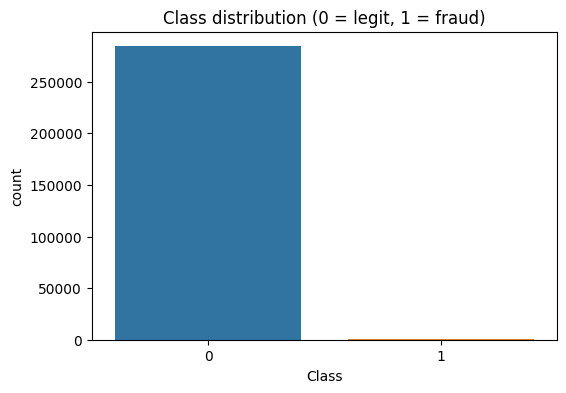

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


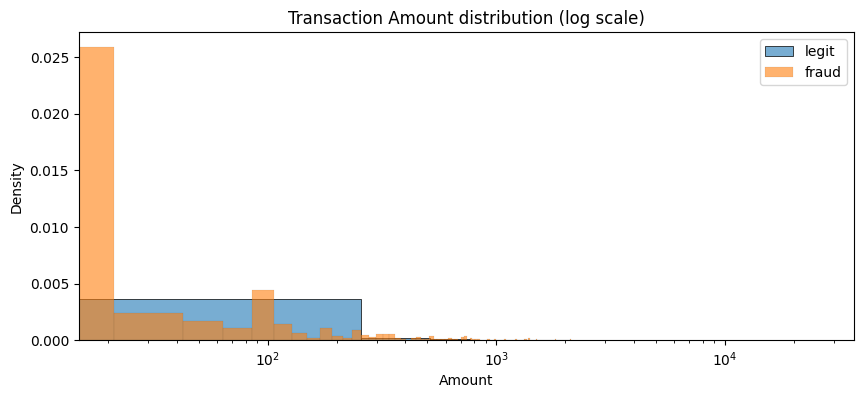

In [3]:
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Class distribution (0 = legit, 1 = fraud)")
plt.show()
plt.figure(figsize=(10,4))
sns.histplot(df[df.Class==0]['Amount'], label='legit', stat='density', bins=100, alpha=0.6)
sns.histplot(df[df.Class==1]['Amount'], label='fraud', stat='density', bins=100, alpha=0.6)
plt.xscale('log')
plt.legend()
plt.title("Transaction Amount distribution (log scale)")
plt.show()

## Preprocessing

Ce bloc de code met en place la préparation des données avant l’entraînement des modèles de détection de fraude. D'abord, la variable cible Class est séparée du reste des caractéristiques : X contient les variables explicatives tandis que y représente la classe de fraude, convertie en type entier. Le code vérifie ensuite la présence éventuelle de variables non numériques, puis ne conserve que les colonnes numériques pour éviter des problèmes lors de l’entraînement des modèles. Les données sont ensuite divisées en un ensemble d’entraînement et un ensemble de test grâce à "train_test_split", tout en maintenant la même proportion de fraudes dans les deux ensembles grâce à l’option stratify. Une standardisation est appliquée à l’aide de "StandardScaler" afin de normaliser les variables, une étape essentielle pour stabiliser et améliorer les performances des algorithmes sensibles aux échelles des données. Enfin, le code affiche la taille des ensembles créés ainsi que la proportion de transactions frauduleuses dans chacun d’eux, ce qui permet de vérifier que la répartition des classes reste cohérente avant l’entraînement des modèles.

In [4]:
X = df.drop("Class", axis=1)
y = df["Class"].astype(int)
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
X = X.select_dtypes(include=[np.number])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Positive class fraction (train):", y_train.mean(), " (test):", y_test.mean())

Train shape: (227845, 30) Test shape: (56962, 30)
Positive class fraction (train): 0.001729245759178389  (test): 0.0017204452090867595


## Train Random Forest

Ce code entraîne un modèle Random Forest. Le modèle est configuré avec 200 arbres décisionnels et utilise class_weight="balanced" afin de compenser automatiquement le déséquilibre entre transactions légitimes et frauduleuses. L’option n_jobs=-1 permet d’utiliser tous les cœurs du processeur pour accélérer l’entraînement. Une fois le modèle ajusté sur les données standardisées d'entraînement grâce à rf.fit, plusieurs prédictions sont générées : les probabilités de fraude pour les ensembles de test et d’entraînement (predict_proba) ainsi que les prédictions binaires correspondantes (predict). Ces sorties seront ensuite utilisées pour évaluer la performance du modèle et éventuellement servir d’entrée à des modèles secondaires dans une approche de stacking. L’impression “RF trained.” confirme simplement que l’entraînement s’est déroulé correctement.

In [5]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_s, y_train)
rf_prob_test = rf.predict_proba(X_test_s)[:,1]
rf_prob_train = rf.predict_proba(X_train_s)[:,1]
rf_pred_test_labels = rf.predict(X_test_s)
rf_pred_train_labels = rf.predict(X_train_s)
print("RF trained.")

RF trained.


## Random Forest evaluation + visualizations

Après l’entraînement du modèle Random Forest. J'ai d’abord généré la matrice de confusion, qui permet d’observer comment le modèle classe réellement les transactions en comparant les prédictions aux étiquettes réelles. Ensuite, la courbe ROC et l’AUC associée mesurent la capacité du modèle à distinguer les transactions légitimes des transactions frauduleuses selon différents seuils de décision. J'ai également tracé la courbe Precision–Recall, plus adaptée aux jeux de données fortement déséquilibrés comme la détection de fraude, ainsi que son score PR-AUC. Pour interpréter le modèle, j'ai visualisé les 15 variables les plus importantes identifiées par le Random Forest, puis calculé des importances par permutation afin d’obtenir une estimation plus fiable de l’influence réelle de chaque variable sur les prédictions. Enfin, le graphique de calibration permet d’évaluer si les probabilités prédites par le modèle correspondent bien aux fréquences réelles de fraude observées.

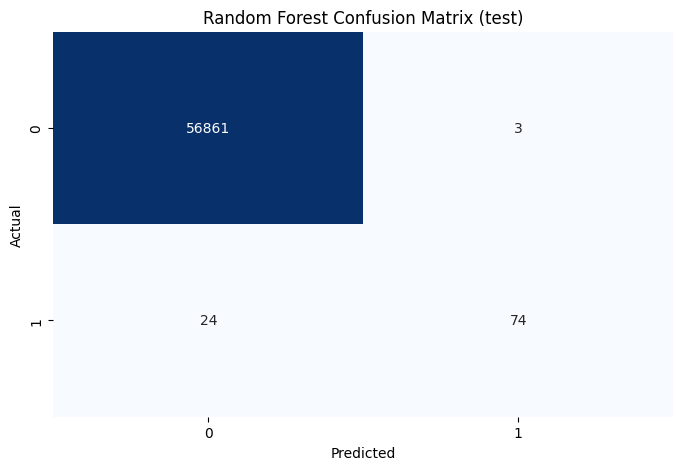

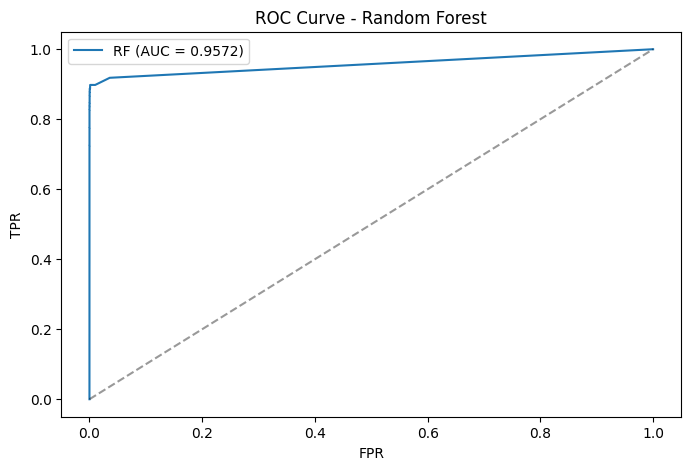

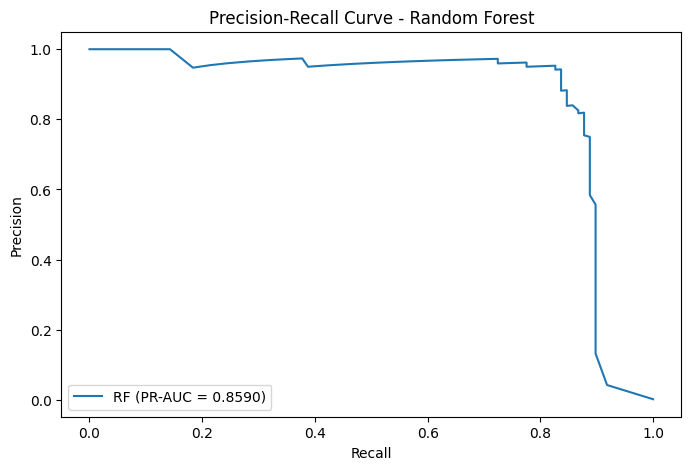

V14       0.172660
V4        0.115420
V10       0.111504
V12       0.093531
V17       0.092372
V3        0.064272
V11       0.058769
V16       0.051421
V2        0.028802
V7        0.025844
V9        0.019119
V21       0.018188
V19       0.012339
Amount    0.011725
V20       0.011525
dtype: float64

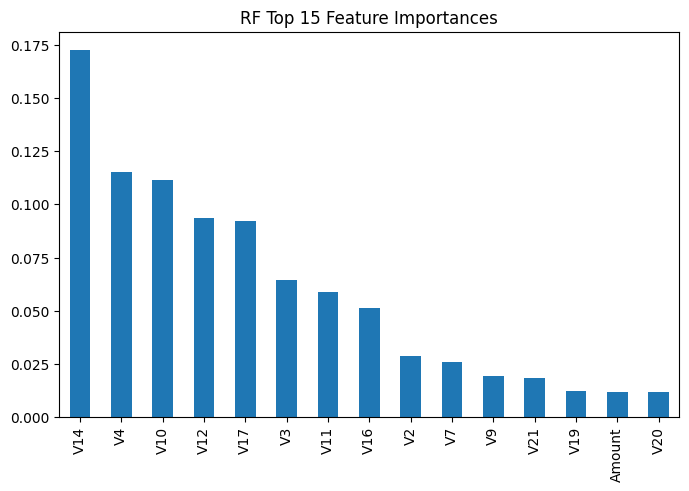

V12    0.001083
V14    0.000966
V11    0.000678
V3     0.000621
V4     0.000611
V10    0.000479
V9     0.000075
V17    0.000054
V1     0.000042
V26    0.000033
dtype: float64

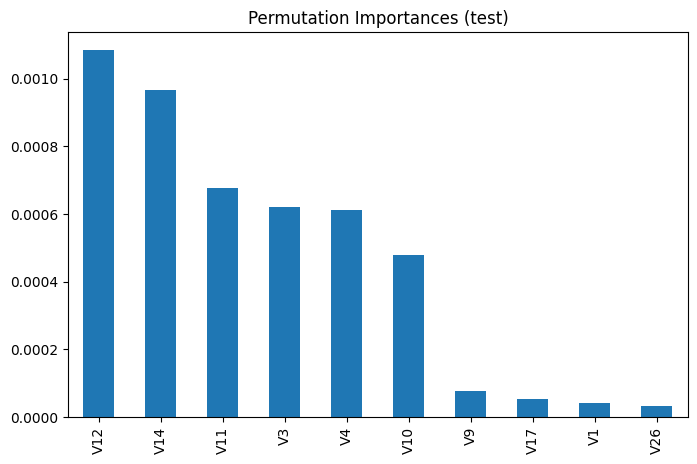

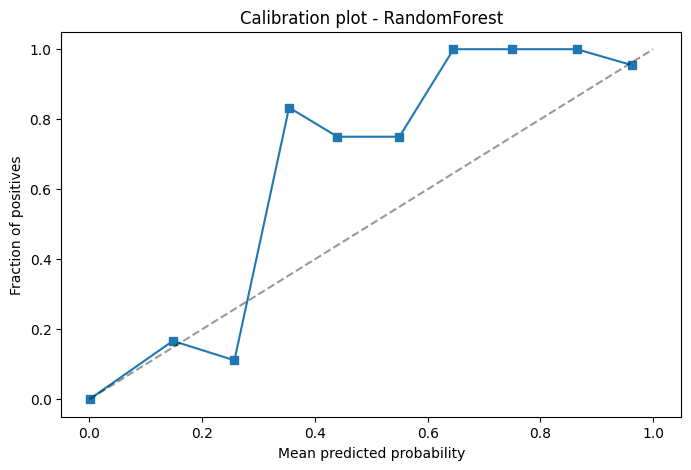

In [6]:
cm = confusion_matrix(y_test, rf_pred_test_labels)
plot_confusion(cm, labels=[0,1], title="Random Forest Confusion Matrix (test)")

fpr, tpr, _ = roc_curve(y_test, rf_prob_test)
roc_auc = roc_auc_score(y_test, rf_prob_test)
plt.plot(fpr, tpr, label=f"RF (AUC = {roc_auc:.4f})")
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, rf_prob_test)
pr_auc = average_precision_score(y_test, rf_prob_test)
plt.plot(recall, precision, label=f"RF (PR-AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.show()

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances.head(15))
importances.head(15).plot(kind='bar')
plt.title("RF Top 15 Feature Importances")
plt.show()

perm = permutation_importance(rf, X_test_s, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
display(perm_importances.head(10))
perm_importances.head(10).plot(kind='bar')
plt.title("Permutation Importances (test)")
plt.show()

prob_true, prob_pred = calibration_curve(y_test, rf_prob_test, n_bins=10)
plt.plot(prob_pred, prob_true, "s-")
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot - RandomForest")
plt.show()

## Prepare meta-features

J'ai préparé les données qui serviront d’entrée aux modèles de niveau supérieur. Pour cela, j'ai récupéré les probabilités prédites par le Random Forest, aussi bien sur l’ensemble d’entraînement que sur l’ensemble de test. Ces probabilités représentent la confiance du modèle qu’une transaction soit frauduleuse. Nous allons les organisé ensuite sous forme de vecteurs colonne, grâce au reshape(-1,1), afin qu’elles puissent être correctement utilisées comme nouvelles variables d’entrée par les modèles neuronaux. Cette transformation permet ainsi de construire un dataset « meta » dans lequel chaque observation n’est plus décrite par plusieurs caractéristiques, mais uniquement par la probabilité fournie par le Random Forest. L’affichage de la forme "meta_X_train.shape" permet de vérifier que la dimension obtenue correspond bien au nombre d’échantillons attendus.

In [7]:
meta_X_train = rf_prob_train.reshape(-1,1)
meta_X_test  = rf_prob_test.reshape(-1,1)
print("meta_X_train shape:", meta_X_train.shape)

meta_X_train shape: (227845, 1)


## Model 1: scikit-learn MLPClassifier

Je vais entrainé un premier modèle neuronal simple, un MLP (Multi-Layer Perceptron) fourni par scikit-learn. Le réseau est composé de deux couches cachées contenant respectivement 32 et 16 neurones, et utilise la fonction d’activation ReLU ainsi que l’optimiseur Adam, ce qui constitue une configuration standard et efficace pour un apprentissage rapide. Le MLP est entraîné uniquement sur les probabilités produites par le Random Forest (meta_X_train), ce qui signifie qu’il joue le rôle d’un modèle de second niveau dans une architecture de stacking. Une fois l’entraînement terminé, le modèle génère des probabilités de fraude sur l’ensemble de test, puis ces probabilités sont converties en prédictions binaires à l’aide d’un seuil de 0.5. Enfin, nous calculons plusieurs métriques avancées afin d’évaluer la performance du MLP et de pouvoir le comparer aux autres modèles.

In [8]:
mlp = MLPClassifier(hidden_layer_sizes=(32,16), activation='relu',
                    solver='adam', max_iter=200, random_state=42)
mlp.fit(meta_X_train, y_train)
mlp_prob = mlp.predict_proba(meta_X_test)[:,1]
mlp_pred = (mlp_prob > 0.5).astype(int)
mlp_metrics = compute_metrics(y_test, mlp_pred, mlp_prob)
print("MLP (sklearn) metrics:", mlp_metrics)

MLP (sklearn) metrics: {'F1': 0.8587570621468926, 'Precision': 0.9620253164556962, 'Recall': 0.7755102040816326, 'ROC-AUC': 0.9571936047913819, 'PR-AUC': 0.8589695598370037, 'MCC': 0.8635448920046104}


## Model 2: PyTorch neural network

Ce code utilise PyTorch pour créer un réseau de neurones destiné à une classification binaire. Les données d’entraînement et de test sont transformées en tenseurs et organisées en petits lots pour faciliter l’apprentissage. Le modèle, appelé TorchNet, comporte plusieurs couches linéaires avec des fonctions d’activation ReLU et un dropout pour éviter le surapprentissage. La perte utilisée est la binary cross-entropy avec un ajustement pour gérer le déséquilibre entre les classes, et les paramètres sont optimisés avec l’algorithme Adam. Le modèle est entraîné sur plusieurs époques, puis évalué sur les données de test, en transformant les sorties en probabilités pour obtenir des prédictions et calculer les performances. Cette approche montre une méthode complète pour entraîner un réseau de neurones sur des données tabulaires.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tr_t = torch.tensor(meta_X_train, dtype=torch.float32)
y_tr_t = torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32)
X_te_t = torch.tensor(meta_X_test, dtype=torch.float32)
y_te_t = torch.tensor(y_test.values.reshape(-1,1), dtype=torch.float32)
train_ds = TensorDataset(X_tr_t, y_tr_t)
train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
class TorchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

model = TorchNet().to(device)
pos = (y_train==1).sum()
neg = (y_train==0).sum()
pos_weight = float(neg / (pos + 1e-12))
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1}/{epochs} loss: {running_loss/len(train_ds):.6f}")
model.eval()
with torch.no_grad():
    logits = model(X_te_t.to(device)).cpu().numpy().flatten()
    torch_prob = 1 / (1 + np.exp(-logits))  # sigmoid
    torch_pred = (torch_prob > 0.5).astype(int)
torch_metrics = compute_metrics(y_test, torch_pred, torch_prob)
print("PyTorch NN metrics:", torch_metrics)

Epoch 1/10 loss: 0.810685
Epoch 2/10 loss: 0.058723
Epoch 3/10 loss: 0.013883
Epoch 4/10 loss: 0.005828
Epoch 5/10 loss: 0.003356
Epoch 6/10 loss: 0.001742
Epoch 7/10 loss: 0.001544
Epoch 8/10 loss: 0.000901
Epoch 9/10 loss: 0.000764
Epoch 10/10 loss: 0.000660
PyTorch NN metrics: {'F1': 0.8791208791208791, 'Precision': 0.9523809523809523, 'Recall': 0.8163265306122449, 'ROC-AUC': 0.9571936047913819, 'PR-AUC': 0.8589695598370037, 'MCC': 0.8815489362933638}


## Model 3: Keras/TensorFlow simple net

Ce code utilise TensorFlow et Keras pour créer un réseau de neurones destiné à une classification binaire. Le modèle Sequential contient trois couches : une première couche dense de 32 neurones avec activation ReLU et une entrée d’une dimension, un dropout de 20 % pour réduire le surapprentissage, puis une deuxième couche dense de 16 neurones avec ReLU et une couche de sortie avec activation sigmoïde pour produire une probabilité. Le modèle est compilé avec l’optimiseur Adam et la fonction de perte binary cross-entropy, et il est évalué sur l’AUC. L’entraînement se fait sur 10 époques avec des batches de 1024 échantillons. Après l’entraînement, les probabilités sont converties en prédictions binaires à l’aide d’un seuil de 0,5, puis des métriques de performance sont calculées. Si TensorFlow ou Keras n’est pas disponible, le code utilise un réseau de neurones alternatif avec scikit-learn MLPClassifier comme solution de secours, entraînant un modèle avec deux couches cachées et calculant les mêmes métriques sur les données de test.

In [10]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    tf.get_logger().setLevel("ERROR")
    kmodel = Sequential([
        Dense(32, activation='relu', input_shape=(1,)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    kmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    kmodel.fit(meta_X_train, y_train, epochs=10, batch_size=1024, verbose=1)
    kprob = kmodel.predict(meta_X_test).flatten()
    kpred = (kprob > 0.5).astype(int)
    keras_metrics = compute_metrics(y_test, kpred, kprob)
    print("Keras metrics:", keras_metrics)
except Exception as e:
    print("Keras/TensorFlow unavailable or error occurred:", e)
    print("Falling back to second sklearn MLP as Model 3.")
    mlp2 = MLPClassifier(hidden_layer_sizes=(64,32), activation='relu', max_iter=200, random_state=42)
    mlp2.fit(meta_X_train, y_train)
    mlp2_prob = mlp2.predict_proba(meta_X_test)[:,1]
    mlp2_pred = (mlp2_prob > 0.5).astype(int)
    keras_metrics = compute_metrics(y_test, mlp2_pred, mlp2_prob)
    print("Fallback MLP metrics:", keras_metrics)

2025-12-08 20:59:09.649482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765227549.895600      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765227549.965462      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-08 20:59:43.433825: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.5617 - loss: 0.4746
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 1.0000 - loss: 0.0171
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9955 - loss: 0.0036
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 1.0000 - loss: 6.6991e-04
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 1.0000 - loss: 2.6249e-04
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9955 - loss: 1.3505e-04
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 1.0000 - loss: 1.0139e-04
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 1.0000 - loss: 8.8734e-05
Epoch 9/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 1.0000 - loss: 6.4061e-05
Epoch 10/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 1.0000 - loss: 3.8630e-05
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Keras metrics: {'F1': 0.8729281767955801, 'Precision': 0.9518072289156626, 'Recall': 0.8061224489795918, 'ROC-AUC': 0.95965633721

## Train XGBoost & LightGBM (Kaggle models)

Ce code utilise les bibliothèques XGBoost et LightGBM pour entraîner deux modèles de classification binaire basés sur des arbres de décision. Pour XGBoost, les données d’entraînement et de test sont converties en DMatrix, puis le modèle est entraîné avec l’objectif binary:logistic et 100 itérations de boosting, en évaluant la performance avec l’AUC. Les probabilités prédites sont ensuite transformées en classes binaires avec un seuil de 0,5, et des métriques de performance sont calculées. Pour LightGBM, les données sont mises dans un Dataset, le modèle est entraîné avec un objectif binaire et également 100 tours de boosting, puis les probabilités sont converties en prédictions binaires pour calculer les métriques. Si XGBoost ou LightGBM n’est pas installé, le code affiche simplement un message et passe à l’autre modèle.

In [11]:
xgb_metrics = None
lgb_metrics = None
if xgb is not None:
    dtrain = xgb.DMatrix(meta_X_train, label=y_train)
    dtest = xgb.DMatrix(meta_X_test, label=y_test)
    params = {"objective":"binary:logistic", "eval_metric":"auc", "verbosity":0}
    xgb_model = xgb.train(params, dtrain, num_boost_round=100)
    xgb_prob = xgb_model.predict(dtest)
    xgb_pred = (xgb_prob > 0.5).astype(int)
    xgb_metrics = compute_metrics(y_test, xgb_pred, xgb_prob)
    print("XGBoost metrics:", xgb_metrics)
else:
    print("xgboost not installed; skipping.")
if lgb is not None:
    ltrain = lgb.Dataset(meta_X_train, label=y_train)
    lparams = {"objective":"binary", "metric":"auc", "verbosity":-1}
    lgb_model = lgb.train(lparams, ltrain, num_boost_round=100)
    lgb_prob = lgb_model.predict(meta_X_test)
    lgb_pred = (lgb_prob > 0.5).astype(int)
    lgb_metrics = compute_metrics(y_test, lgb_pred, lgb_prob)
    print("LightGBM metrics:", lgb_metrics)
else:
    print("lightgbm not installed; skipping.")

XGBoost metrics: {'F1': 0.8255813953488371, 'Precision': 0.9594594594594594, 'Recall': 0.7244897959183674, 'ROC-AUC': 0.9563380905963962, 'PR-AUC': 0.7190058456888103, 'MCC': 0.8335011333842014}
LightGBM metrics: {'F1': 0.8457142857142858, 'Precision': 0.961038961038961, 'Recall': 0.7551020408163265, 'ROC-AUC': 0.9437880966258198, 'PR-AUC': 0.8393405431793304, 'MCC': 0.8516532279164988}


## Plot ROC & PR curves for all models

Ce code génère des graphiques pour comparer visuellement les performances de plusieurs modèles sur le dataset de détection de fraude par carte bancaire. Il crée une liste de modèles et de leurs probabilités prédites, incluant Random Forest, MLP scikit-learn, réseaux de neurones PyTorch, Keras, ainsi que XGBoost et LightGBM La première figure affiche les courbes ROC de chaque modèle, avec le calcul de l’AUC pour mesurer la capacité à distinguer correctement les transactions frauduleuses des transactions normales. La deuxième figure montre les courbes Precision-Recall, avec le calcul de la moyenne de précision (PR-AUC), ce qui est particulièrement utile pour évaluer la performance sur la classe minoritaire des fraudes, cruciale pour limiter les risques financiers.

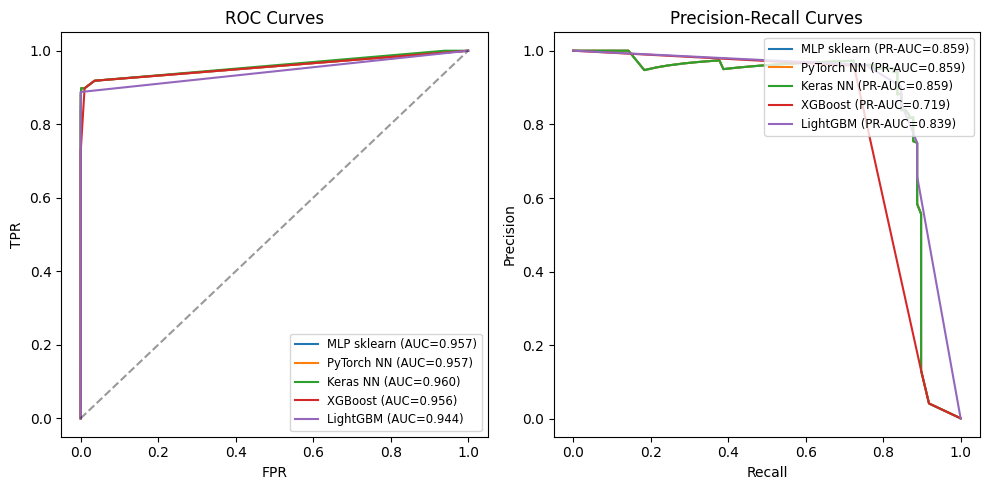

In [15]:
plt.figure(figsize=(10,5))
models = []
models.append(("MLP sklearn", mlp_prob))
models.append(("PyTorch NN", torch_prob))
if 'kprob' in locals():
    models.append(("Keras NN", kprob))
else:
    models.append(("MLP2 (fallback)", mlp2_prob if 'mlp2_prob' in locals() else np.zeros_like(rf_prob_test)))

if xgb_metrics is not None:
    models.append(("XGBoost", xgb_prob))
if lgb_metrics is not None:
    models.append(("LightGBM", lgb_prob))

plt.subplot(1,2,1)
for name, prob in models:
    try:
        fpr, tpr, _ = roc_curve(y_test, prob)
        auc = roc_auc_score(y_test, prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    except Exception:
        pass
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.title("ROC Curves")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right", fontsize='small')

plt.subplot(1,2,2)
for name, prob in models:
    try:
        prec, rec, _ = precision_recall_curve(y_test, prob)
        pra = average_precision_score(y_test, prob)
        plt.plot(rec, prec, label=f"{name} (PR-AUC={pra:.3f})")
    except Exception:
        pass
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right", fontsize='small')
plt.tight_layout()
plt.show()

## Confusion matrices for all models

Ce code organise et affiche les matrices de confusion pour comparer les performances des différents modèles sur le jeu de données de détection de fraude par carte bancaire. Les métriques de chaque modèle sont stockées dans le dictionnaire all_metrics. Pour chaque modèle, la matrice de confusion montre le nombre de transactions correctement identifiées comme frauduleuses ou normales et celles mal classées, ce qui permet d’évaluer la capacité du modèle à détecter les fraudes tout en limitant les fausses alertes. Cette visualisation est particulièrement utile dans ce contexte, car elle met en évidence la performance sur la classe minoritaire (fraude), qui est critique pour la sécurité financière.

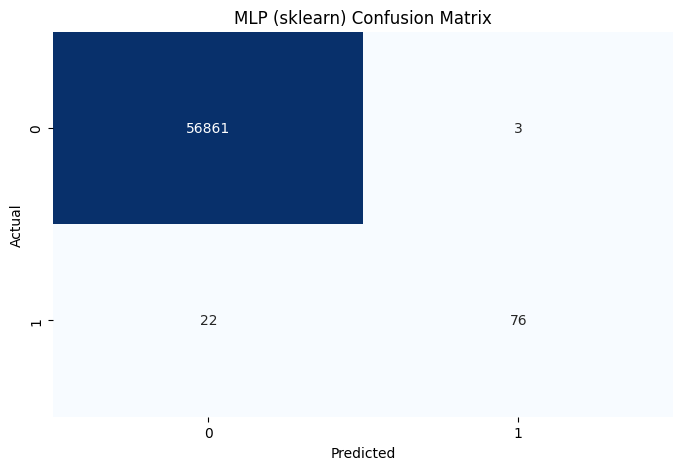

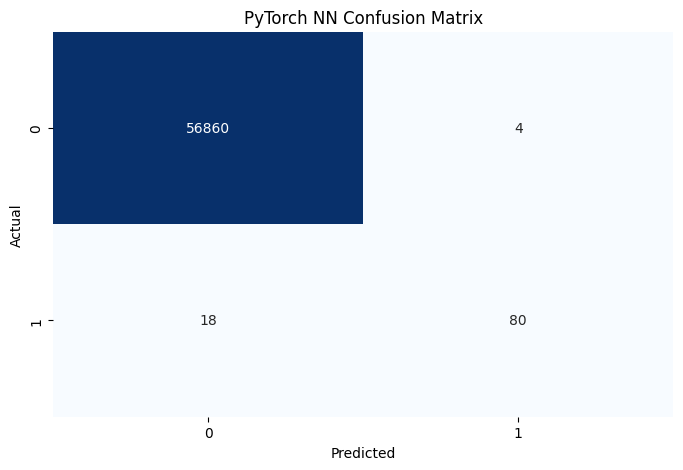

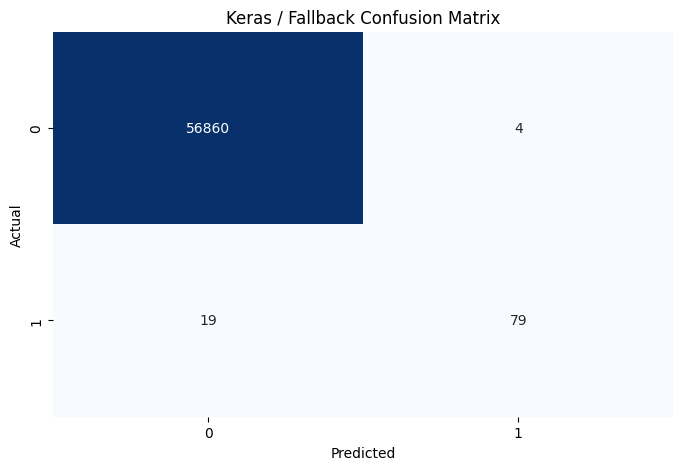

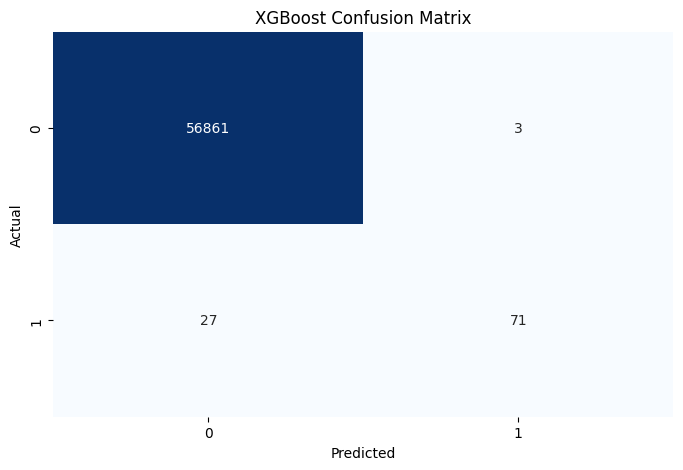

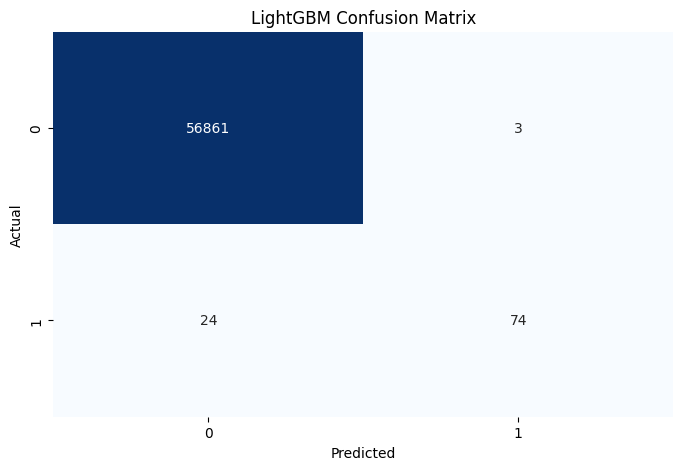

In [13]:
all_metrics = {}

all_metrics["MLP_sklearn"] = mlp_metrics
plot_confusion(confusion_matrix(y_test, mlp_pred), title="MLP (sklearn) Confusion Matrix")

all_metrics["PyTorch"] = torch_metrics
plot_confusion(confusion_matrix(y_test, torch_pred), title="PyTorch NN Confusion Matrix")

all_metrics["Keras_or_Fallback"] = keras_metrics
if 'kprob' in locals():
    kpred_show = kpred
else:
    kpred_show = (mlp2_prob > 0.5).astype(int) if 'mlp2_prob' in locals() else np.zeros_like(rf_pred_test_labels)
plot_confusion(confusion_matrix(y_test, kpred_show), title="Keras / Fallback Confusion Matrix")

if xgb_metrics is not None:
    all_metrics["XGBoost"] = xgb_metrics
    plot_confusion(confusion_matrix(y_test, xgb_pred), title="XGBoost Confusion Matrix")
if lgb_metrics is not None:
    all_metrics["LightGBM"] = lgb_metrics
    plot_confusion(confusion_matrix(y_test, lgb_pred), title="LightGBM Confusion Matrix")

## Result table & save

Ce code rassemble et organise les résultats de performance de tous les modèles. Pour chaque modèle, les métriques  sont copiées et associées au nom du modèle, puis stockées dans une liste. Cette liste est ensuite convertie en DataFrame Pandas, avec le nom des modèles comme index, ce qui permet de comparer facilement les performances de tous les modèles. Enfin, le tableau est affiché et sauvegardé dans un fichier CSV model_comparison_results.csv.

In [14]:
results = []
for name, m in all_metrics.items():
    res = m.copy()
    res["Model"] = name
    results.append(res)
results_df = pd.DataFrame(results).set_index("Model")
display(results_df)
results_df.to_csv("model_comparison_results.csv")
print("Saved model_comparison_results.csv")

,F1,Precision,Recall,ROC-AUC,PR-AUC,MCC
Model,,,,,,
MLP_sklearn,0.858757,0.962025,0.775510,0.957194,0.858970,0.863545
PyTorch,0.879121,0.952381,0.816327,0.957194,0.858970,0.881549
Keras_or_Fallback,0.872928,0.951807,0.806122,0.959656,0.858979,0.875749
XGBoost,0.825581,0.959459,0.724490,0.956338,0.719006,0.833501
LightGBM,0.845714,0.961039,0.755102,0.943788,0.839341,0.851653


Saved model_comparison_results.csv


## Conclusion

D'après les métriques d’évaluation, le modèle PyTorch présente les meilleures performances globales, avec le F1-score le plus élevé (0,879), le Recall le plus élevé (0,816) et le coefficient de corrélation de Matthews (MCC) le plus élevé (0,882), tout en conservant un ROC-AUC solide (0,957). Cela indique qu’il équilibre efficacement l’identification des cas positifs et la performance globale de classification, mieux que les autres modèles. Comparativement, XGBoost et LightGBM présentent des valeurs de F1 et de Recall légèrement inférieures, indiquant un possible sous-apprentissage ou une moindre sensibilité à la classe minoritaire. Globalement, PyTorch offre le meilleur compromis entre précision et généralisation, minimisant à la fois le sous-apprentissage et le surapprentissage, tandis que MLP_sklearn et Keras obtiennent de bonnes performances mais restent légèrement en retrait sur le Recall et le MCC par rapport à PyTorch.